<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Hands-on/04-text-mining/Sentiment_Analysis_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Course: BA820 - Unsupervised and Unstructured ML**

**Notebook created by: Mohannad Elhamod**

# Book Review Dataset


In this notebook, we are working with a dataset of book reviews to develop a model that provides deeper insights beyond just numerical ratings.  

- We aim to compare ratings with a detailed analysis of the review text.  
- We want to extract sentiment scores for different aspects of the review, such as the story, writing style, and character development.  
- We may need to discard reviews where the text and the numerical rating show a clear disagreement.  


## Loading The Data

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("qmaruf/goodreads-rating")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset_df = ds["train"].to_pandas()
dataset_df.drop(columns=["book_id", "user_id", "review_id", "date_added", "date_updated", "read_at", "started_at", "n_votes","n_comments"], inplace=True)
dataset_df = dataset_df.sample(frac=0.02, random_state=42)

In [ ]:
dataset_df

,rating,review_text
527984,4,I'm proudly telling you that I'm a big fan of ...
618093,4,"4.25 stars \n This was so, so much better than..."
484217,3,For some reason finding a good male lead urban...
161123,4,It's about the son of a pepper merchant who fi...
718642,4,the most beautiful display of emotions in this...
...,...,...
333527,4,AH SO GOOD WHY DOES NO LIBRARY HAVE THE 4TH ON...
213710,4,I will say I was struggling a bit with this bo...
676714,4,"I liked this book. It was a little creepy, but..."
70240,2,I selected this book because it was the last b...


In [ ]:
dataset_df.iloc[0]["review_text"]

"I'm proudly telling you that I'm a big fan of Quinn now! \n Such a perfect gentleman. Almost seems too good to be true LOL. \n I practically loathe Jason since the first book. He doesn't get any better. And Sookie's always been the one to clean up the mess. \n Sookie is such a sweet and responsible woman. I like her tenderness, and in this book we learn a shocking fact about Bill. I don't get why Bill keep saying that he loves Sookie, but he's still going out with another woman. Wouldn't it be better if he just break up with that woman and trying to regain Sookie's trust? \n Afterall, I'm Team Sookie. :)"

A train/test split might be useful.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset_df["review_text"], dataset_df["rating"], test_size=0.2, random_state=42)

## Text Cleaner

It might come in handy

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # Get the set of stop words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import string
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def cleanup_text(sentence):
  # First, word tokenize.
  tokenized_sms_messages = word_tokenize(sentence)

  # Lower case
  # tokenized_sms_messages = [word.lower() for word in tokenized_sms_messages]

  # Remove punctuation
  # tokenized_sms_messages = [word for word in tokenized_sms_messages if word not in string.punctuation]

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  tokenized_sms_messages = [word for word in tokenized_sms_messages if word not in stop_words]

  # Stem
  # tokenized_sms_messages = [ps.stem(word) for word in tokenized_sms_messages]

  return tokenized_sms_messages

## Task 1: Training Our Own Sentiment Analysis Model

Let's say we want to train a model that reflects a review's sentiment based on its text.

We will treat the rating as a proxy for the sentiment in this case.

First we need to convert from rating to sentiment.

In [ ]:
dataset_df["sentiment"] = dataset_df["rating"].apply(lambda x: ) # different criteria may apply here

Let's use Mean GloVe-50 for embeddings

In [ ]:
import gensim.downloader as api

# Load the pretrained model
pretrained_model = api.load('glove-wiki-gigaword-50')

import numpy as np

vector_size = pretrained_model.vector_size  # Get the embedding size

tokenized_reviews = dataset_df["review_text"].apply(cleanup_text)

embeddings = list(map(lambda tokenized_review: pretrained_model.get_mean_vector(tokenized_review) if len(tokenized_review) > 0 else np.zeros(vector_size), tokenized_reviews))

Let's apply KNN (K-Nearest Neighbors) as a classifier.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd

def assess_model(df, X, y_column):
  # train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, df[y_column], test_size=0.2, random_state=42)

  # train the model
  classifier = KNeighborsClassifier()
  classifier.fit(X_train, y_train)

  # Predict on the test data
  y_pred = classifier.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  f1_score = sklearn.metrics.f1_score(y_test, y_pred, pos_label="positive")
  print(f"Accuracy: {accuracy}")
  print(f"f1_score: {f1_score}")
  print(sklearn.metrics.classification_report(y_test,y_pred))
  display(pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'), columns=classifier.classes_, index=classifier.classes_ ))



In [ ]:
assess_model(dataset_df, embeddings, "sentiment")

Accuracy: 0.8394444444444444
f1_score: 0.9119975639464069
              precision    recall  f1-score   support

    negative       0.30      0.05      0.09       541
    positive       0.85      0.98      0.91      3059

    accuracy                           0.84      3600
   macro avg       0.58      0.51      0.50      3600
weighted avg       0.77      0.84      0.79      3600



,negative,positive
negative,0.049908,0.950092
positive,0.020922,0.979078


It seems the model is biases towards positive reviews. Some things we could try:

- Different text clean-up/preprocessing steps.
- Different embedding techniques.
- Different classifiers
- Dataset balancing techniques (e.e., over sampling, undersampling, class-weighting).
- Changing the conversion threshold.

## Task 2: Using a `huggingface` model.

Let's try to find a suitable `huggingface` model.

Watch out for suitability (e.g., Was the the model trained on data in the appropriate language, text type, ...?)

Let's say we decide to pick this model: [`siebert/sentiment-roberta-large-english`](https://huggingface.co/siebert/sentiment-roberta-large-english)

### Trying An API Approach

Instead of downloading the mode, let's try to use the API!

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install transformers

In [ ]:
### Using some ChatGPT, we could get this code to work. ###

from huggingface_hub import InferenceClient
from transformers import AutoTokenizer

# Read API key from a file
with open("api_key.txt", "r") as f:
    api_key = f.read().strip()  # Remove any leading/trailing spaces or newlines

# Create an API called with the API key
client = InferenceClient(
	provider="hf-inference",
	api_key=api_key
)

# Load the tokenizer for the specific model
tokenizer =

# The model does not accept text longer than 512 tokens
def truncate_text(text, max_length=512):
    # Tokenize and truncate the text
    tokens = tokenizer(text, truncation=True, max_length=max_length)
    # Decode tokens back to text
    return tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

# Call the API for an example review
result = client.text_classification(
	model="siebert/sentiment-roberta-large-english",
	text=,
)

# Parse the response to get positive or negative


'POSITIVE'

Let's apply the API approach to all our reviews

In [ ]:
truncated_reviews = dataset_df["review_text"].apply(truncate_text).to_list()
truncated_reviews

In [ ]:
%%timeit -r 1 -n 1

embeddings = list(
    map(lambda review: client.  (

    ) ### get the answer lower case here
    , truncated_reviews)
)

print(embeddings)


KeyboardInterrupt: 

This approach might be more resource-concious, but it is somewhat slow. You may also have a limited number of calls a day.

Let's download the model and use our GPU resouces so we could speed things up.

### Downloading The Model

In [ ]:
# Use a pipeline as a high-level helper


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9988991022109985}]

Remember, these models are HUGE and computationally DEMANDING. **We need to use a GPU**, which is a more expensive resource.

**Remember to DISCONNECT** when done.

In [ ]:
def assess_model_huggingface(df, X_column, y_column):
  # train/test split
  X_train, X_test, y_train, y_test = train_test_split(df[X_column], df[y_column], test_size=0.2, random_state=42)

  # Predict on the test data
  y_pred = ## apply pipe to whe whole test set and then extract labels and lower case. Don't forget to truncate!

  # Getting class labels for pretty printing
  class_labels = np.unique(np.concatenate((y_test, y_pred)))

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  f1_score = sklearn.metrics.f1_score(y_test, y_pred, pos_label="positive")
  print(f"Accuracy: {accuracy}")
  print(f"f1_score: {f1_score}")
  print(sklearn.metrics.classification_report(y_test,y_pred))
  display(pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'), columns=class_labels, index=class_labels ))


In [ ]:
assess_model_huggingface(dataset_df, "review_text", "sentiment")


Accuracy: 0.8483333333333334
f1_score: 0.9057971014492754
              precision    recall  f1-score   support

    negative       0.50      0.79      0.61       541
    positive       0.96      0.86      0.91      3059

    accuracy                           0.85      3600
   macro avg       0.73      0.83      0.76      3600
weighted avg       0.89      0.85      0.86      3600



,negative,positive
negative,0.792976,0.207024
positive,0.141876,0.858124


## Task 3: Extracting Different Aspects of Sentimentality

Let's say we are interested in a specific sentiment: "Whether the movie was exciting". But, we neither have a pre-trained model for this nor the data to train such a model ourselves.

In this case, let's try an **unsupervised approach**.

We will use an embedding model to extract embeddings from the reviews, and then we will measure their similarity to a reference word/sentence/phrase.

We will use a [`SentenceTransformer`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [ ]:
from sentence_transformers import SentenceTransformer

sentences = ["What an exciting movie!"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.
embeddings.shape

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(1, 384)

To get a score for whether a movie review indicates excitement, we compare it to exactly that!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset_df["review_text"], dataset_df["rating"], test_size=0.2, random_state=42)

In [ ]:
# Get the embedding for all reviews
embeddings_train = model
embeddings_test = model.

In [ ]:
embeddings_train.shape

(14400, 384)

Let's create two reference points for the exciting vs. boring movies and compare to them.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

positive_reference_embedding = model.encode(    ).reshape(1, -1)
negative_reference_embedding = model.encode(     ).reshape(1, -1)

def get_excitement_score(embeddings):
  return

training_cosine_scores = get_excitement_score(embeddings_train)

threshold =  0.020089814


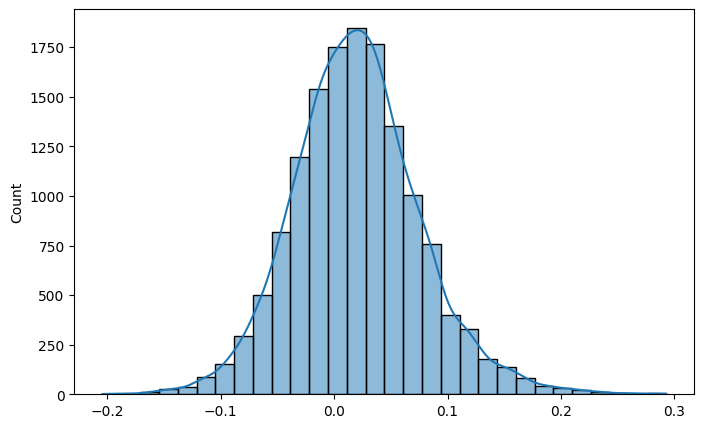

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of similarity scores
plt.figure(figsize=(8, 5))
sns.histplot(training_cosine_scores.reshape(-1), bins=30, kde=True)

threshold_train = np.mean(training_cosine_scores)
print("threshold = ", threshold_train)

Let's make sure this threshold works for the test set

In [ ]:
test_cosine_scores = get_excitement_score(embeddings_test)
threshold_test = np.mean(test_cosine_scores)
print("threshold = ", threshold_test)

threshold =  0.01956284


In [ ]:
training_cosine_scores.shape

(1, 14400)

We could standardize to place the mean at zero.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create Scalar
scaler = StandardScaler()
scaler.fit(training_cosine_scores.reshape(-1, 1))

# Get the embeddings
embeddings = model.encode(dataset_df["review_text"].tolist())

# Get the scores
excitement_score = get_excitement_score(embeddings)

# Scale the scores
dataset_df["excitement_score"] =  scaler.transform(excitement_score.reshape(-1, 1)).reshape(-1).tolist() # Get the sentiment score.

# Threshold the scores
dataset_df["exciting?"] = dataset_df["excitement_score"].apply(lambda x:   ) # Threshold it.

In [ ]:
dataset_df

,rating,review_text,sentiment,excitement_score,exciting?
527984,4,I'm proudly telling you that I'm a big fan of ...,positive,0.078876,yes
618093,4,"4.25 stars \n This was so, so much better than...",positive,0.375628,yes
484217,3,For some reason finding a good male lead urban...,positive,-0.952967,no
161123,4,It's about the son of a pepper merchant who fi...,positive,0.450335,yes
718642,4,the most beautiful display of emotions in this...,positive,1.963256,yes
...,...,...,...,...,...
333527,4,AH SO GOOD WHY DOES NO LIBRARY HAVE THE 4TH ON...,positive,0.661145,yes
213710,4,I will say I was struggling a bit with this bo...,positive,-0.033688,no
676714,4,"I liked this book. It was a little creepy, but...",positive,0.769501,yes
70240,2,I selected this book because it was the last b...,negative,-0.144065,no


Let's sort the reviews by score and see if our approach is working well.

In [ ]:
index = int(dataset_df["review_text"].shape[0]/2)

dataset_df.sort_values(by="excitement_score", ascending=False)["review_text"].iloc[index]

'Occasionally funny and quite informative.'

## **Questions:**

- How would you use the concepts you learned here to discard ratings that do not match with the review's sentiment?
- Would TF-IDF yield good unsupervised sentiment analysis results? Why or why not?
- Would a mean pre-trained `word2vec` model yield good unsupervised sentiment analysis results? Why or why not?
- You are asked to devise an unsupervised approach for detecting how political a review. How would you go about implementing that?